In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from scipy.signal import convolve2d
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import eigsh, eigs
import os
import cv2

2024-04-22 17:05:24.753169: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 17:05:24.781119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 17:05:25.232206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(data, label), _ = mnist.load_data()
print('Shape of data:', data.shape)
print('Number of labels:', len(label))

Shape of data: (60000, 28, 28)
Number of labels: 60000


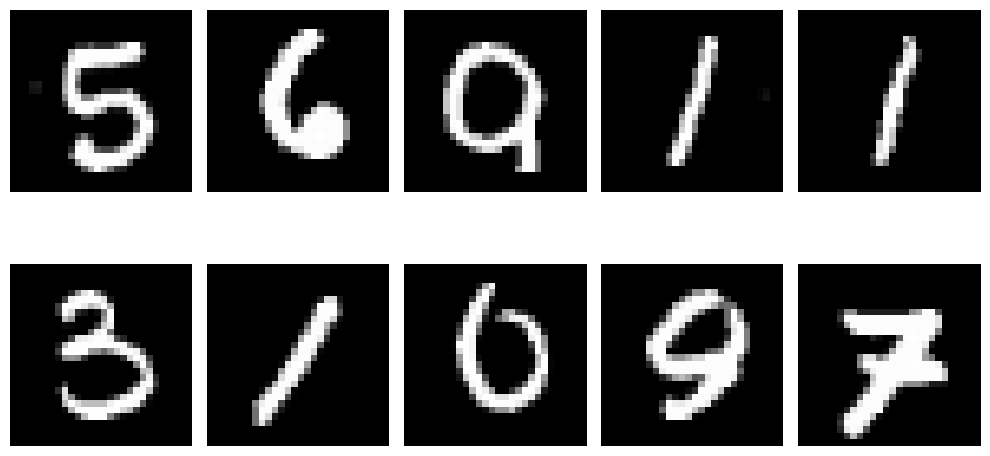

In [3]:
# visulization of MNIST

indices = np.random.choice([i for i in range(data.shape[0])], size=10, replace=False)

fig = plt.figure(figsize=(10, 6))

for i, index in enumerate(indices):
    img = data[index]
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

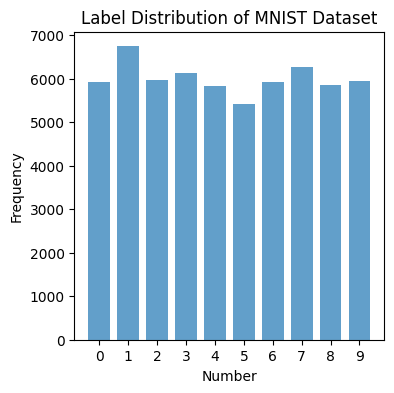

In [4]:
# distribution of labels

fig = plt.figure(figsize=(4, 4))

plt.hist(label, bins=np.arange(-0.5, 10.5, 1), rwidth=0.75, alpha=0.7)
plt.title('Label Distribution of MNIST Dataset')
plt.xticks(range(0,10))
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.show()

# Preprocessing

### convolve 2 times with an average filter (3 x 3 all ones matrix)

In [5]:
def smooth(img, filter_size=3, num_iter=2):
    average_filter = np.ones((filter_size, filter_size)) / (filter_size ** 2)

    for i in range(num_iter):
        smoothed_img = convolve2d(img, average_filter, mode='same')

    return smoothed_img

data_smoothed = np.array([smooth(img) for img in data])

In [6]:
data_smoothed.shape

(60000, 28, 28)

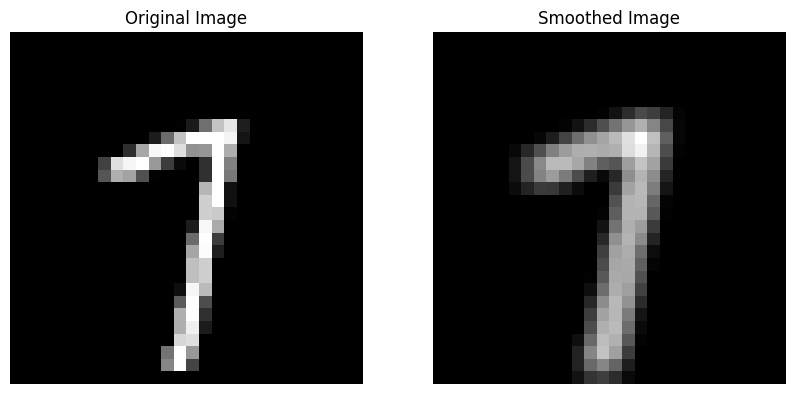

In [7]:
# visualize the image before and after smoothing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(data[42], cmap='gray')
ax1.set_title("Original Image")
ax1.axis('off')

ax2.imshow(data_smoothed[42], cmap='gray')
ax2.set_title("Smoothed Image")
ax2.axis('off')

plt.show()

### use top 50 PCA

In [8]:
# flatten
data_flatten = data_smoothed.reshape(data_smoothed.shape[0], -1)

pca = PCA(n_components=50)
data_pca = pca.fit_transform(data_flatten)

data_pca.shape

(60000, 50)

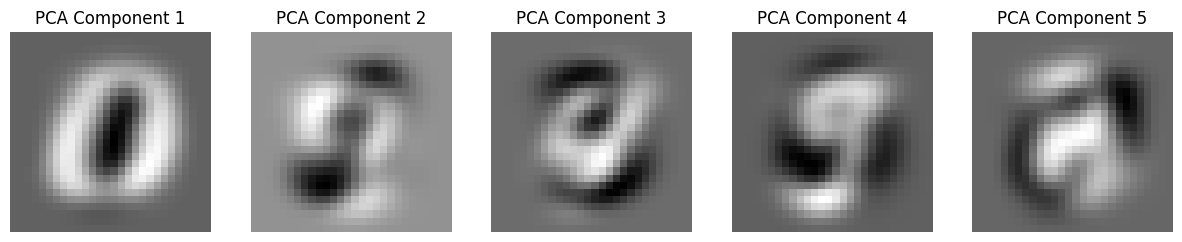

In [9]:
# visualize the first few principal components as images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(pca.components_[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'PCA Component {i+1}')
    ax.axis('off')
plt.show()

# Graph construction

In [10]:
def graph_construction(X, k, m, sigma=1):
    """
    X: data
    k: k-th neareast neighbors
    m: self-tuning neighbor index (m<k)
    sigma: local time
    """
    
    # includes the point itself as the 0-th nearest
    knn = NearestNeighbors(n_neighbors=k+1, algorithm='auto', metric='euclidean')

    knn.fit(X)

    # Get the k nearest neighbors for each data point
    distances, indices = knn.kneighbors(X)
    
    # Compute self-tuning weights
    num_points = X.shape[0]
    W_dense = np.zeros((num_points, num_points))

    for i in range(num_points):
        # j-th neareast neighbor for normalization
        for j in range(k+1):
            # Normalize distances by the m-th nearest neighbor of i
            rho_x = distances[i, j] / distances[i, m] 
            # Normalize distances by the m-th nearest neighbor of  j
            rho_y = distances[i, j] / distances[indices[i, j], m]  
            weight = np.exp(-(rho_x * rho_y) / sigma)
            # Assign weight symmetrically
            W_dense[i, indices[i, j]] += weight
            W_dense[indices[i, j], i] += weight

    # create self-tuning weight matrix
    W_dense /= 2
    # Convert dense matrix to sparse format
    W = csr_matrix(W_dense)

    return W

In [11]:
def laplacian(W):
    # Degree matrix
    degrees = np.asarray(W.sum(axis=1)).flatten()
    D = diags(degrees)

    # Laplacian matrix
    L = D - W

    return L

def eigenfunction(L, num_eigenv):
    """
    calculate num_eigenv smallest eigenvalues
    """
    eigenvalues, eigenvectors = eigsh(L, k=num_eigenv, which='SM')

    return eigenvalues, eigenvectors

In [12]:
def coefficients(X, y):
    """
    calculate least-square solution 
    """
    coef = np.linalg.lstsq(X, y, rcond=None)[0]

    return coef

def pred_label(X, coef):
    """
    predict labels
    """
    y_pred = X.dot(coef)

    return y_pred

def acc(y_pred, y_true):
    """
    calculate prediction accuracy
    """
    acc = np.sum(y_pred == y_true)/len(y_true)

    return acc

def classifier_train(X, y, indices, num_class=10):
    """
    train classifier for each class
    
    X: Feature matrix
    y: Label vector
    indices: Indices of labels 
    """
    classifier = []

    for i in range(num_class):
        y_i = (y==i).astype(int)
        coef = coefficients(X[indices], y_i[indices])
        classifier.append(coef)

    return classifier

def classifier_evaluate(X, classifier):
    """
    predict labels for each sample
    """
    predictions = np.zeros((X.shape[0], len(classifier)))
    for i, coef in enumerate(classifier):
        predictions[:, i]=pred_label(X, coef)

    # Predicted labels based on the highest prediction score per sample
    return np.argmax(predictions, axis=1), predictions

# test algorithm on MNIST

In [20]:
k = 9
m = 8
sigma = 1
num_eigenv = 20

In [21]:
img = data_pca[:10000]
labels = label[:10000]

# choose first 500 data to be labeled
num_labels = 500
labeled_indices = np.arange(num_labels)
unlabeled_indices = np.arange(num_labels, 10000)

# graph construction
W = graph_construction(img, k, m, sigma)

L = laplacian(W)
eigenvalues, eigenvectors = eigenfunction(L, num_eigenv)

classfiers = classifier_train(eigenvectors, labels, labeled_indices)

y_pred, y_score = classifier_evaluate(eigenvectors[unlabeled_indices], classfiers)
accuracy = acc(y_pred, labels[unlabeled_indices])
print(f"Classification accuracy: {accuracy:.4f}")

Classification accuracy: 0.9369


# cross validation on eigenfunctions

In [28]:
def data_split(num_img, num_labeled, num_split):
    """
    split data into labeled and unlabeled for cross validation
    
    return: indices of labeled and unlabeled data
    """
    labeled_indices = []
    unlabeled_indices = []
    for split in range(num_split):
        indices = np.random.permutation(num_img)
        labeled = indices[:num_labeled]
        unlabeled = indices[num_labeled:]
        labeled_indices.append(labeled)
        unlabeled_indices.append(unlabeled)

    return labeled_indices, unlabeled_indices


def cross_val_eigenfunc(L, labels, labeled_indices, unlabeled_indices, num_eigenvec, num_class=10):
    """
    Use cross-validation to find the optimal number of eigenvectors for embedding.

    L: Laplacian matrix
    labels: true labels
    labeled_indices(list): indices of labeled data for different cross-validation splits
    unlabeled_indices(list): indices of unlabeled data corresponding to each split in labeled_indices
    num_eigenvec(list): different numbers of eigenfunctions to evaluate.
    """
    error_rate = np.zeros((len(num_eigenvec), len(labeled_indices)))
    
    for index, num_eigenvectors in enumerate(num_eigenvec):
        eigenvalues, eigenvectors = eigenfunction(L, num_eigenvectors)

        # Nested Loop Over Each Cross-validation Split
        for split, (labeled, unlabeled) in enumerate(zip(labeled_indices, unlabeled_indices)):
            classifiers = classifier_train(eigenvectors, labels, labeled, num_class)
            y_pred, y_score = classifier_evaluate(eigenvectors[unlabeled], classifiers)
            accuracy = acc(y_pred, labels[unlabeled])  
            error_rate[index, split] = 1 - accuracy
            # print(f" Number of eigenvectors: {num_eigenvectors}, Error rate: {1-accuracy:.4f}")

    return error_rate


# test cross validation

In [25]:
k = 9
m = 8
sigma = 1

img = data_pca[:10000]
labels = label[:10000]

W = graph_construction(img, k, m, sigma)
L = laplacian(W)

num_eigenvec = np.arange(10, 51, 10)
# 10 fold cross validation
labeled_indices, unlabeled_indices = data_split(10000, 500, 10)
error_rate = cross_val_eigenfunc(L, labels, labeled_indices, unlabeled_indices, num_eigenvec)

 Number of eigenvectors: 10, Error rate: 0.1722
 Number of eigenvectors: 10, Error rate: 0.1789
 Number of eigenvectors: 10, Error rate: 0.1778
 Number of eigenvectors: 10, Error rate: 0.1433
 Number of eigenvectors: 10, Error rate: 0.1764
 Number of eigenvectors: 10, Error rate: 0.1634
 Number of eigenvectors: 10, Error rate: 0.1767
 Number of eigenvectors: 10, Error rate: 0.1589
 Number of eigenvectors: 10, Error rate: 0.1740
 Number of eigenvectors: 10, Error rate: 0.1733
 Number of eigenvectors: 20, Error rate: 0.0605
 Number of eigenvectors: 20, Error rate: 0.0597
 Number of eigenvectors: 20, Error rate: 0.0645
 Number of eigenvectors: 20, Error rate: 0.0595
 Number of eigenvectors: 20, Error rate: 0.0658
 Number of eigenvectors: 20, Error rate: 0.0594
 Number of eigenvectors: 20, Error rate: 0.0593
 Number of eigenvectors: 20, Error rate: 0.0625
 Number of eigenvectors: 20, Error rate: 0.0615
 Number of eigenvectors: 20, Error rate: 0.0651
 Number of eigenvectors: 30, Error rate:

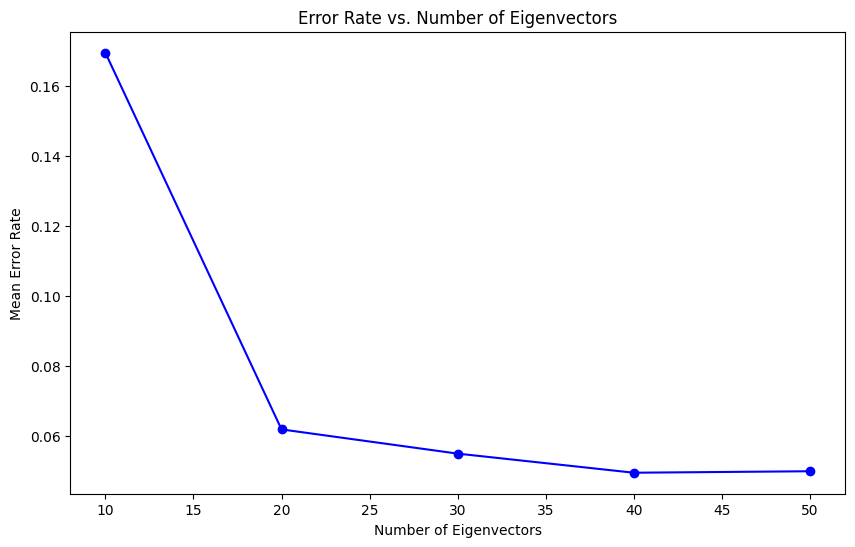

In [27]:
mean_error_rates = error_rate.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(num_eigenvec, mean_error_rates, marker='o', linestyle='-', color='b')
plt.title('Error Rate vs. Number of Eigenvectors')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Mean Error Rate')
plt.show()

# Error rate vs. number of eigenvectors

In [54]:
# graph parameters
k = 9
m = 8
sigma = 1

# number of data
num_img = [5000, 10000, 30000, 60000]
# number of cross validation fold
num_split = 10
# number of eigenvectors
num_eigenvec = np.arange(10, 201, 10)
# number of labeled data
num_labeled = 1000

error_rates = []
for num in num_img:
    img = data_pca[:num]
    labels = label[:num]

    W = graph_construction(img, k, m, sigma)
    L = laplacian(W)

    # 10 fold cross validation
    labeled_indices, unlabeled_indices = data_split(num, num_labeled, num_split)
    error_rate = cross_val_eigenfunc(L, labels, labeled_indices, unlabeled_indices, num_eigenvec)
    
    mean_error_rate = error_rate.mean(axis=1)
    error_rates.append(mean_error_rate)

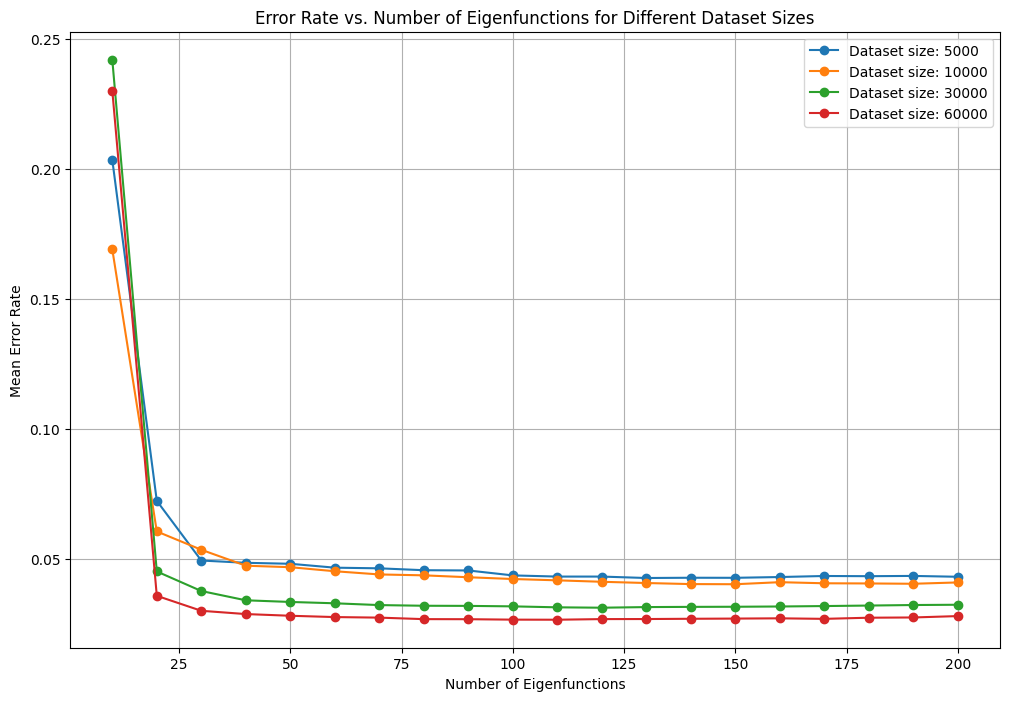

In [55]:
plt.figure(figsize=(12, 8))

for i, rates in enumerate(error_rates):
    plt.plot(num_eigenvec, rates, marker='o', linestyle='-', label=f'Dataset size: {num_img[i]}')

plt.title('Error Rate vs. Number of Eigenfunctions for Different Dataset Sizes')
plt.xlabel('Number of Eigenfunctions')
plt.ylabel('Mean Error Rate')
plt.legend()
plt.grid(True)
plt.show()

# Error rate vs. number of labeled data

In [28]:
# graph parameters
k = 9
m = 8
sigma = 1

# number of data
num_img = 10000
# number of cross validation fold
num_split = 10
# number of eigenvectors
num_eigenvec = np.arange(10, 201, 10)
# number of labeled data
num_labeled = [100, 250, 500, 1000, 2500, 5000]

img = data_pca[:num_img]
labels = label[:num_img]

W = graph_construction(img, k, m, sigma)
L = laplacian(W)

error_rates = []
for num in num_labeled:
    # 10 fold cross validation
    labeled_indices, unlabeled_indices = data_split(num_img, num, num_split)
    error_rate = cross_val_eigenfunc(L, labels, labeled_indices, unlabeled_indices, num_eigenvec)
    
    mean_error_rate = error_rate.mean(axis=1)
    error_rates.append(mean_error_rate)

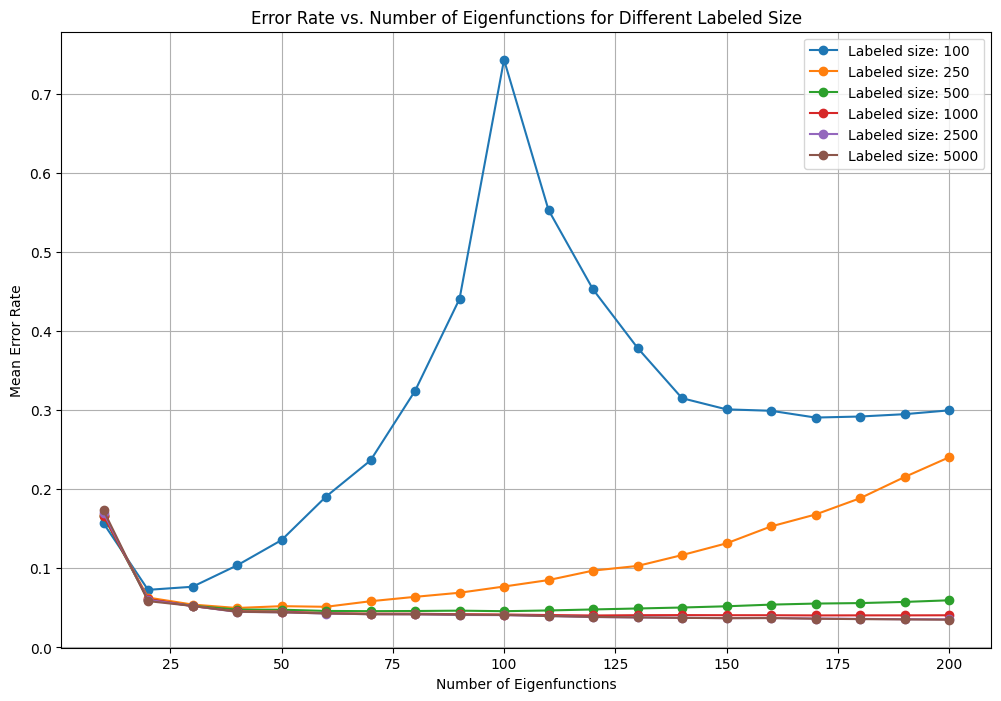

In [29]:
plt.figure(figsize=(12, 8))

for i, rates in enumerate(error_rates):
    plt.plot(num_eigenvec, rates, marker='o', linestyle='-', label=f'Labeled size: {num_labeled[i]}')

plt.title('Error Rate vs. Number of Eigenfunctions for Different Labeled Size')
plt.xlabel('Number of Eigenfunctions')
plt.ylabel('Mean Error Rate')
plt.legend()
plt.grid(True)
plt.show()

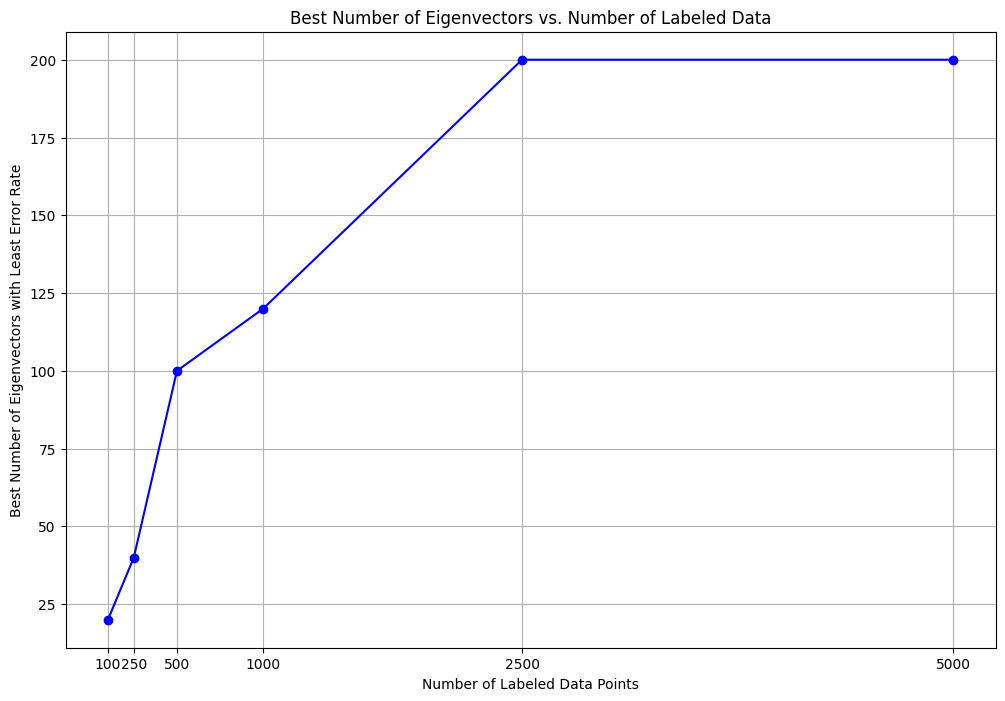

In [30]:
best_num_eigenvectors = []
min_error_rates = []

# Find the best number of eigenvectors for each labeled data size
for error_rate in error_rates:
    # Find the index of the minimum mean error rate across splits for each number of eigenvectors
    min_error_index = np.argmin(error_rate)
    min_error_rates.append(error_rate[min_error_index])
    # Append the best number of eigenvectors which corresponds to the minimum mean error rate
    best_num_eigenvectors.append(num_eigenvec[min_error_index])

# Now you have the best number of eigenvectors for each labeled data size
# Let's plot the number of labeled data against the best number of eigenvectors

plt.figure(figsize=(12, 8))
plt.plot(num_labeled, best_num_eigenvectors, marker='o', linestyle='-', color='b')
plt.title('Best Number of Eigenvectors vs. Number of Labeled Data')
plt.xlabel('Number of Labeled Data Points')
plt.ylabel('Best Number of Eigenvectors with Least Error Rate')
plt.xticks(num_labeled)  # Set x-ticks to be explicit about the number of labeled points
plt.grid(True)
plt.show()

# COIL20 dataset

In [2]:
directory = "./dataset/"

images = []
labels = []

for filename in os.listdir(directory):
    if filename.endswith(".png"):
        # Read the image 
        image = cv2.imread(os.path.join(directory, filename))
        
        # Extract the label from the filename
        label = int(filename.split("obj")[1].split("_")[0]) 
        
        # Append the image and label to the respective lists
        images.append(image)
        labels.append(label)

# Print the number of loaded images and labels
print("Number of images loaded:", len(images))
print("Number of labels loaded:", len(labels))

Number of images loaded: 1440
Number of labels loaded: 1440


In [4]:
processed_images = []

for image in images:
    # Convert the image from RGB to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    processed_images.append(grayscale_image)

processed_images = np.array(processed_images)

# Print the shape of the processed images array
print("Shape of processed images:", processed_images.shape)

Shape of processed images: (1440, 128, 128)


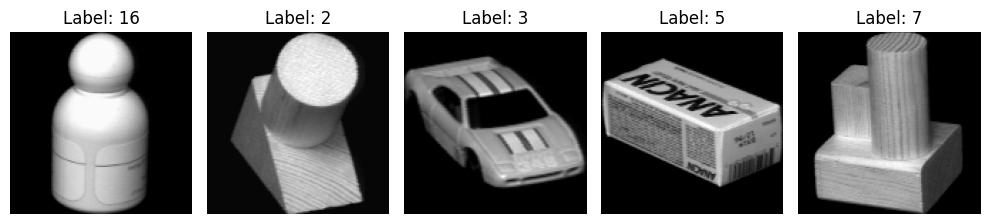

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3))

for i in range(5):
    
    image = processed_images[i]
    label = labels[i]

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')


plt.tight_layout()
plt.show()

In [6]:
np.save('processed_images.npy', processed_images)
np.save('labels.npy', labels)

In [2]:
data = np.load('processed_images.npy')
labels = np.load('labels.npy')

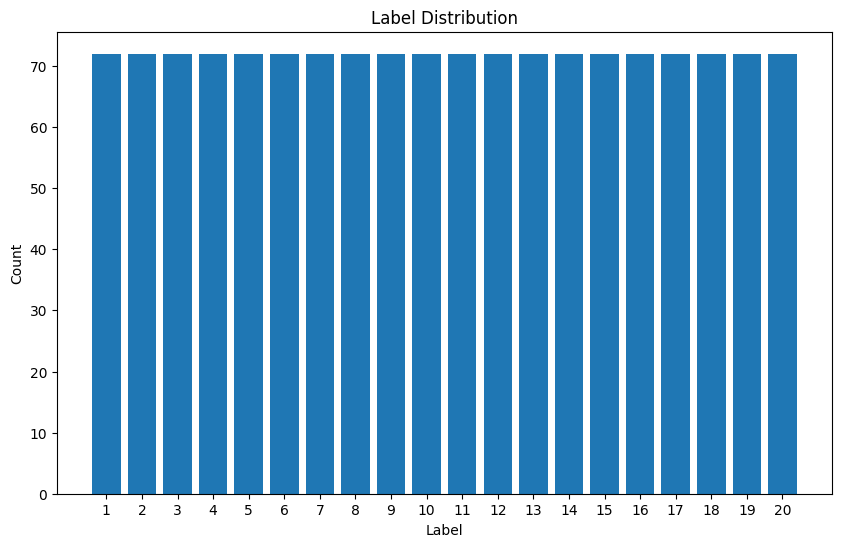

In [3]:
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)

# Customize the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(unique_labels)

# Display the plot
plt.show()

# preprocess

In [6]:
# convolution 3x3 2 times
data_smoothed = np.array([smooth(img) for img in data])

data_flatten = data_smoothed.reshape(data_smoothed.shape[0], -1)
pca = PCA(n_components=100)
data_pca = pca.fit_transform(data_flatten)

data_pca.shape

(1440, 100)

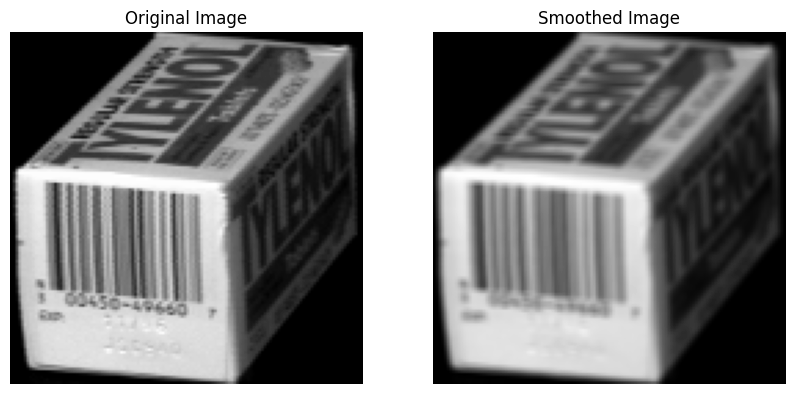

In [7]:
# visualize the image before and after smoothing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(data[42], cmap='gray')
ax1.set_title("Original Image")
ax1.axis('off')

ax2.imshow(data_smoothed[42], cmap='gray')
ax2.set_title("Smoothed Image")
ax2.axis('off')

plt.show()

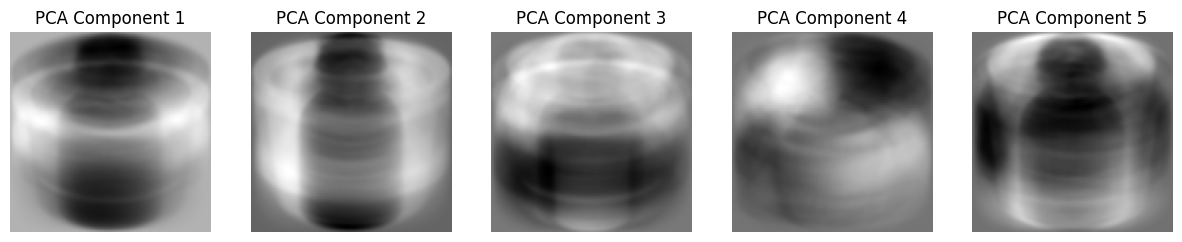

In [8]:
# visualize the first few principal components as images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(pca.components_[i].reshape(128, 128), cmap='gray')
    ax.set_title(f'PCA Component {i+1}')
    ax.axis('off')
plt.show()

# test algorithm on COIL20

In [25]:
k = 25
m = 20
sigma = 1
num_eigenv = 50

img = data_pca[:1000]
label = labels[:1000]

# choose first 100 data to be labeled
num_labels = 250
labeled_indices = np.arange(num_labels)
unlabeled_indices = np.arange(num_labels, 1000)

# graph construction
W = graph_construction(img, k, m, sigma)

L = laplacian(W)
eigenvalues, eigenvectors = eigenfunction(L, num_eigenv)

classifiers = classifier_train(eigenvectors, label, labeled_indices, 20)

y_pred, y_score = classifier_evaluate(eigenvectors[unlabeled_indices], classifiers)
accuracy = acc(y_pred, labels[unlabeled_indices])
print(f"Classification accuracy: {accuracy:.4f}")

Classification accuracy: 0.8093


In [26]:
num_eigenvec = np.arange(30, 81, 10)
# 10 fold cross validation
labeled_indices, unlabeled_indices = data_split(1000, 200, 10)
error_rate = cross_val_eigenfunc(L, label, labeled_indices, unlabeled_indices, num_eigenvec, 20)

 Number of eigenvectors: 30, Error rate: 0.2225
 Number of eigenvectors: 30, Error rate: 0.2325
 Number of eigenvectors: 30, Error rate: 0.2212
 Number of eigenvectors: 30, Error rate: 0.2137
 Number of eigenvectors: 30, Error rate: 0.2275
 Number of eigenvectors: 30, Error rate: 0.2312
 Number of eigenvectors: 30, Error rate: 0.2250
 Number of eigenvectors: 30, Error rate: 0.2150
 Number of eigenvectors: 30, Error rate: 0.2125
 Number of eigenvectors: 30, Error rate: 0.2137
 Number of eigenvectors: 40, Error rate: 0.2312
 Number of eigenvectors: 40, Error rate: 0.2087
 Number of eigenvectors: 40, Error rate: 0.2137
 Number of eigenvectors: 40, Error rate: 0.2188
 Number of eigenvectors: 40, Error rate: 0.2000
 Number of eigenvectors: 40, Error rate: 0.2488
 Number of eigenvectors: 40, Error rate: 0.2338
 Number of eigenvectors: 40, Error rate: 0.2125
 Number of eigenvectors: 40, Error rate: 0.2050
 Number of eigenvectors: 40, Error rate: 0.2137
 Number of eigenvectors: 50, Error rate:

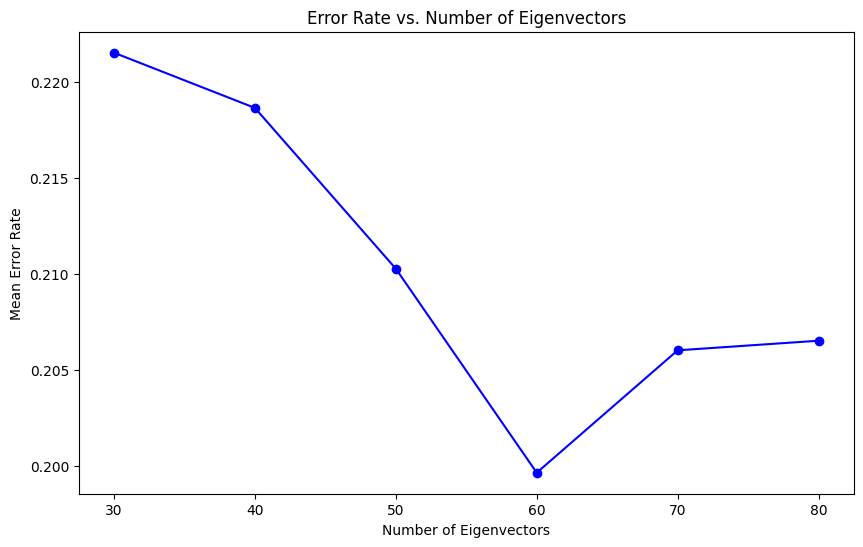

In [27]:
mean_error_rates = error_rate.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(num_eigenvec, mean_error_rates, marker='o', linestyle='-', color='b')
plt.title('Error Rate vs. Number of Eigenvectors')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Mean Error Rate')
plt.show()

# Error rate vs. number of eigenvectors

In [34]:
# number of data
num_img = [200, 500, 1000, 1440]
# number of cross validation fold
num_split = 10
# number of eigenvectors
num_eigenvec = np.arange(30, 151, 10)
# number of labeled data
num_labeled = 100

error_rates = []
for num in num_img:
    img = data_pca[:num]
    label = labels[:num]

    W = graph_construction(img, k, m, sigma)
    L = laplacian(W)

    # 10 fold cross validation
    labeled_indices, unlabeled_indices = data_split(num, num_labeled, num_split)
    error_rate = cross_val_eigenfunc(L, label, labeled_indices, unlabeled_indices, num_eigenvec, 20)
    
    mean_error_rate = error_rate.mean(axis=1)
    error_rates.append(mean_error_rate)

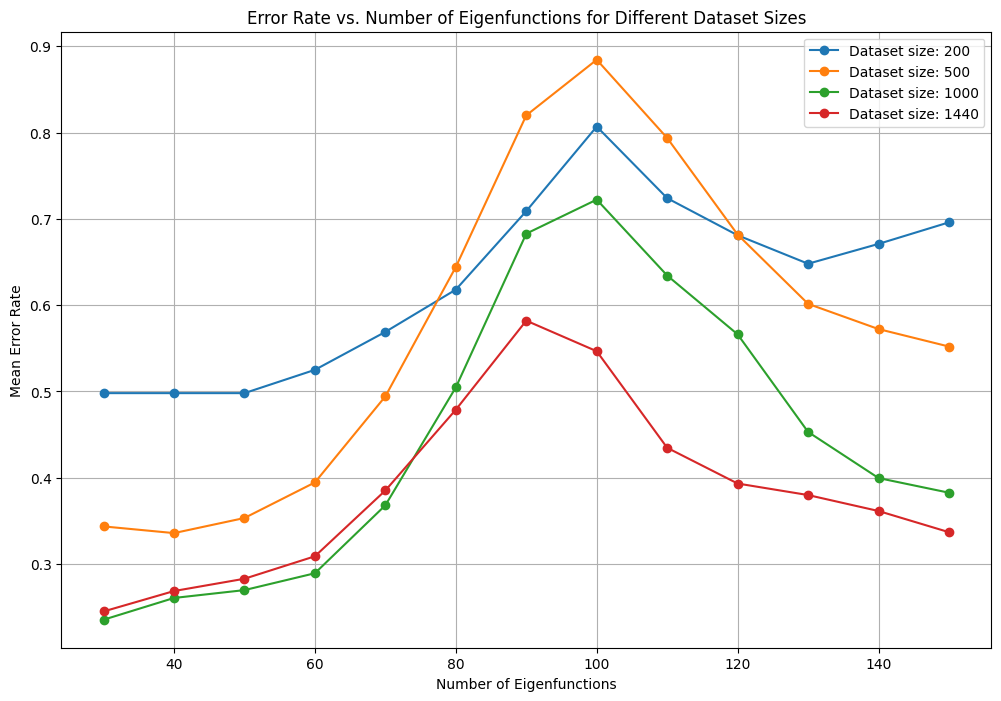

In [35]:
plt.figure(figsize=(12, 8))

for i, rates in enumerate(error_rates):
    plt.plot(num_eigenvec, rates, marker='o', linestyle='-', label=f'Dataset size: {num_img[i]}')

plt.title('Error Rate vs. Number of Eigenfunctions for Different Dataset Sizes')
plt.xlabel('Number of Eigenfunctions')
plt.ylabel('Mean Error Rate')
plt.legend()
plt.grid(True)
plt.show()

# Error rate vs. number of labeled data

In [36]:
# number of data
num_img = 1440
# number of cross validation fold
num_split = 10
# number of eigenvectors
num_eigenvec = np.arange(30, 151, 10)
# number of labeled data
num_labeled = [50, 100, 200, 500, 700]

img = data_pca[:num_img]
label = labels[:num_img]

W = graph_construction(img, k, m, sigma)
L = laplacian(W)

error_rates = []
for num in num_labeled:
    # 10 fold cross validation
    labeled_indices, unlabeled_indices = data_split(num_img, num, num_split)
    error_rate = cross_val_eigenfunc(L, label, labeled_indices, unlabeled_indices, num_eigenvec, 20)
    
    mean_error_rate = error_rate.mean(axis=1)
    error_rates.append(mean_error_rate)

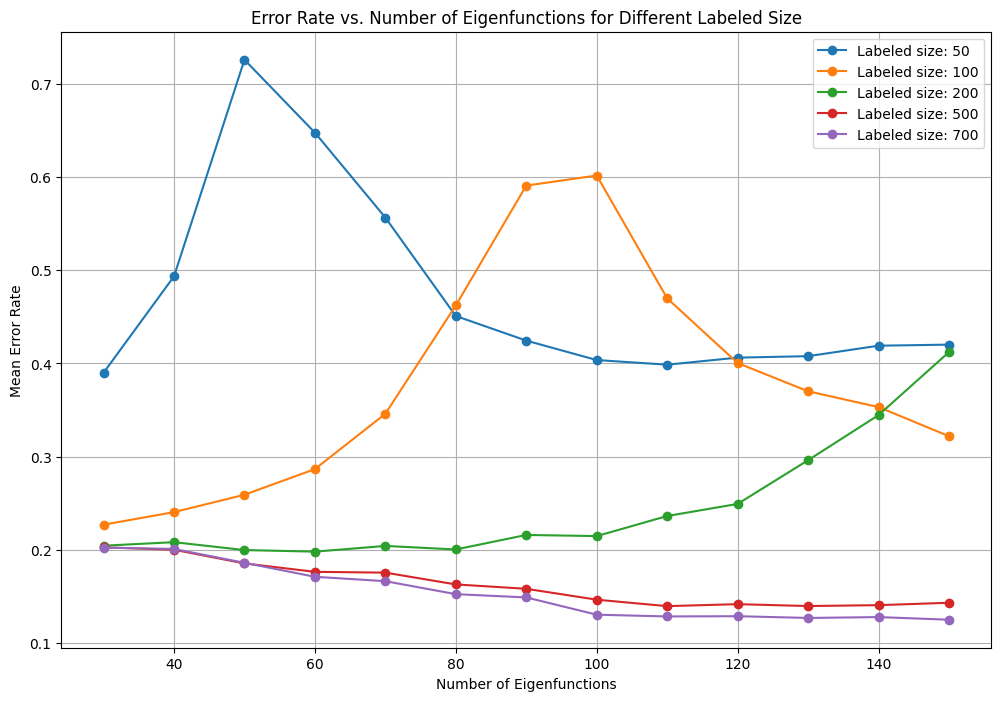

In [37]:
plt.figure(figsize=(12, 8))

for i, rates in enumerate(error_rates):
    plt.plot(num_eigenvec, rates, marker='o', linestyle='-', label=f'Labeled size: {num_labeled[i]}')

plt.title('Error Rate vs. Number of Eigenfunctions for Different Labeled Size')
plt.xlabel('Number of Eigenfunctions')
plt.ylabel('Mean Error Rate')
plt.legend()
plt.grid(True)
plt.show()

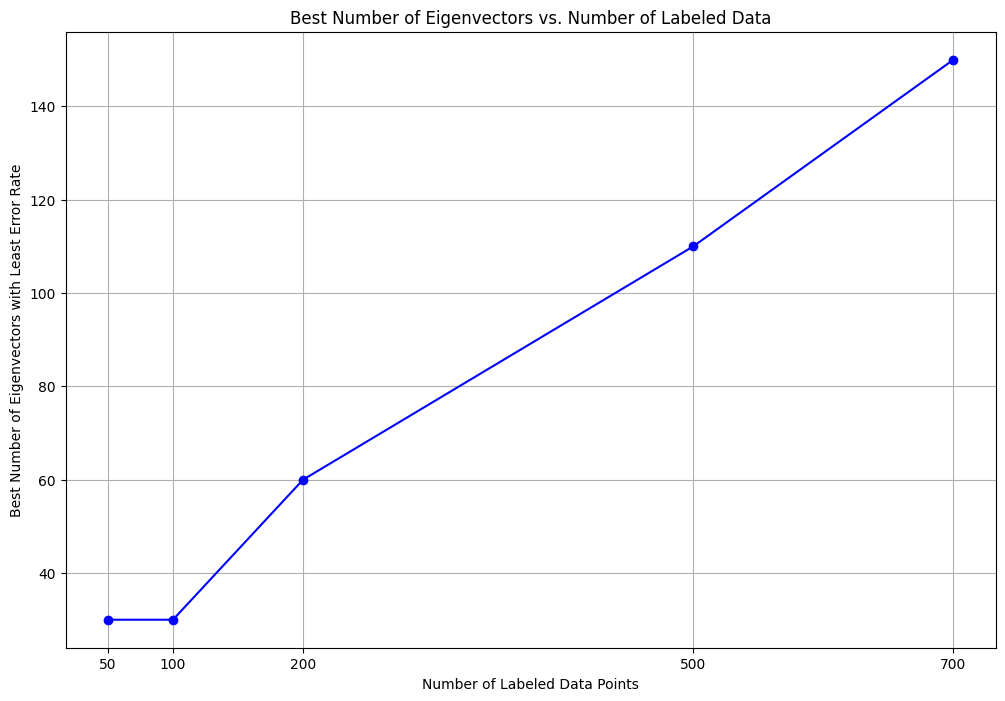

In [38]:
best_num_eigenvectors = []
min_error_rates = []

# Find the best number of eigenvectors for each labeled data size
for error_rate in error_rates:
    # Find the index of the minimum mean error rate across splits for each number of eigenvectors
    min_error_index = np.argmin(error_rate)
    min_error_rates.append(error_rate[min_error_index])
    # Append the best number of eigenvectors which corresponds to the minimum mean error rate
    best_num_eigenvectors.append(num_eigenvec[min_error_index])

# Now you have the best number of eigenvectors for each labeled data size
# Let's plot the number of labeled data against the best number of eigenvectors

plt.figure(figsize=(12, 8))
plt.plot(num_labeled, best_num_eigenvectors, marker='o', linestyle='-', color='b')
plt.title('Best Number of Eigenvectors vs. Number of Labeled Data')
plt.xlabel('Number of Labeled Data Points')
plt.ylabel('Best Number of Eigenvectors with Least Error Rate')
plt.xticks(num_labeled)  # Set x-ticks to be explicit about the number of labeled points
plt.grid(True)
plt.show()